# Accessing Syracuse Open Data

- By Michael Fudge

Feel free to use this as a code recipe for access the Syracuse Open Data Sets

In [2]:
!pip install -qq duckdb

In [3]:
import requests 
import pandas as pd
import duckdb
import folium
import seaborn as sns
import matplotlib

Find Your Dataset!

1. [https://data.syr.gov/datasets/](https://data.syr.gov/datasets/)
2. Browse / Choose your data set.
3. Select **View Full Details**
4. Select **View API Explorer** (On the Right-Hand Side)
5. Select **Open In API Explorer**
6. Copy the Query Url to the clipboard


In [13]:
query_url = "https://services6.arcgis.com/bdPqSfflsdgFRVVM/arcgis/rest/services/Copy_of_SCSD_Grade3_ELA_Proficiency_2021(v2)_(1)/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

This code retrieves the data in JSON formatted string, which is de-serialized as a Python data structure.

It will throw an error if the response is not valid, which is an indication of a bad query url or the service is not working.

In [14]:
response = requests.get(query_url)
response.raise_for_status() # throw an error if the response is not valid
data = response.json()

Inspecting the output. All responses have:
- fields (list of fields)
- features (the actual data set)

In [24]:
print(data.keys())

dict_keys(['objectIdFieldName', 'uniqueIdField', 'globalIdFieldName', 'fields', 'features'])


In [25]:
for field in data['fields']:
    print(field['name'])

CensusTract
Poverty_NotProficient
Poverty_Proficient
PovertyPercentage
NonPoverty_NotProficient
NonPoverty_Proficient
NonPovertyPercentage
StudentCount
FID


This loads the dataset into a Pandas Dataframe

In [17]:
df = pd.json_normalize(data['features'])

We can analyze the dataframe in several ways

In [18]:
df.describe()

,attributes.Poverty_NotProficient,attributes.Poverty_Proficient,attributes.PovertyPercentage,attributes.NonPoverty_NotProficient,attributes.NonPoverty_Proficient,attributes.NonPovertyPercentage,attributes.FID
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,0.667351,0.113769,0.781120,0.117607,0.101274,0.218880,28.500000
std,0.234694,0.093697,0.240660,0.195840,0.159764,0.240660,16.309506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.571429,0.039474,0.708791,0.000000,0.000000,0.058612,14.750000
50%,0.702941,0.111111,0.853571,0.067816,0.033908,0.146429,28.500000
75%,0.805882,0.168478,0.941388,0.133333,0.144643,0.291209,42.250000
max,1.000000,0.375000,1.000000,1.000000,0.800000,1.000000,56.000000


If you know SQL, you can query with duck db

In [29]:
sql = '''
    select "attributes.StudentCount", count(*) as rowcount
        from df
        group by "attributes.StudentCount"
'''
query_df = duckdb.query(sql).to_df()
query_df

,attributes.StudentCount,rowcount
0,<=20,37
1,21-50,18
2,None,1


plotting

<Axes: xlabel='attributes.StudentCount'>

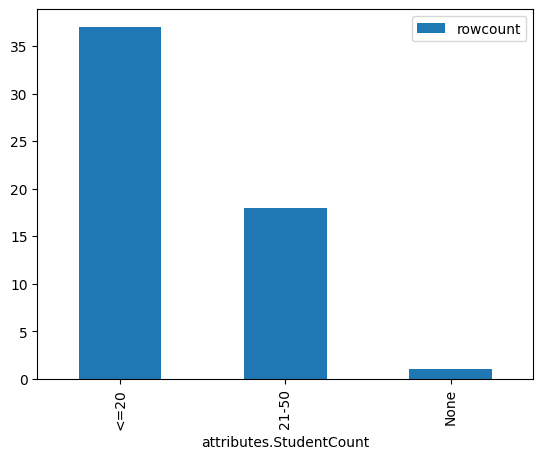

In [31]:
query_df.plot(kind="bar", x="attributes.StudentCount", y = "rowcount")

## Maps example


In [47]:
query_url = "https://services6.arcgis.com/bdPqSfflsdgFRVVM/arcgis/rest/services/a1e239/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
response = requests.get(query_url)
response.raise_for_status()
data = response.json()
df = pd.json_normalize(data['features'])

In [48]:
cuse_map = folium.Map(location=[43.0493, -76.1455], zoom_start=12)
for index, row in df.dropna().iterrows():
    folium.features.CircleMarker([row['geometry.y'], row['geometry.x']], radius=7, fill_color='blue', fill_opacity=0.3,
                                 popup='Location: ' + str(row['attributes.location'])).add_to(cuse_map)

cuse_map